## Linear model 

In [1]:
!pip install -q sklearn

You should consider upgrading via the '/Users/didi/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [3]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [4]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
dftrain.shape[0],dfeval.shape[0]

(627, 264)

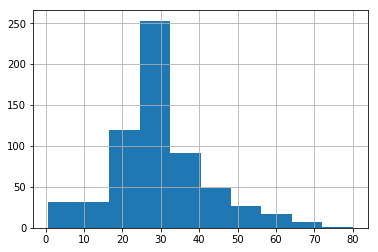

In [8]:
dftrain.age.hist(bins=10)

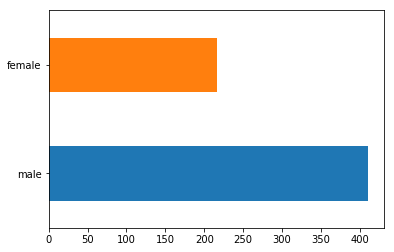

In [9]:
dftrain.sex.value_counts().plot(kind='barh')

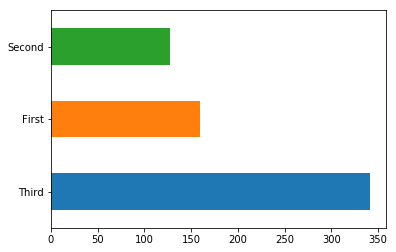

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

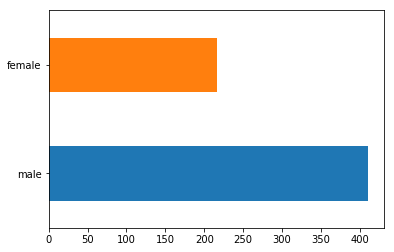

In [11]:
dftrain['sex'].value_counts().plot(kind='barh')

In [12]:
dftrain['sex'].value_counts()

male      410
female    217
Name: sex, dtype: int64

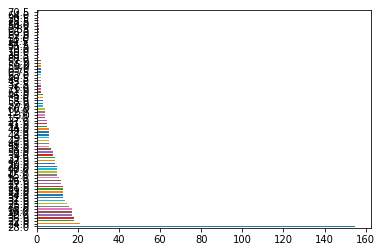

In [13]:
dftrain.age.value_counts().plot(kind='barh')

In [14]:
dfeval.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [15]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

Text(0.5,0,'% survive')

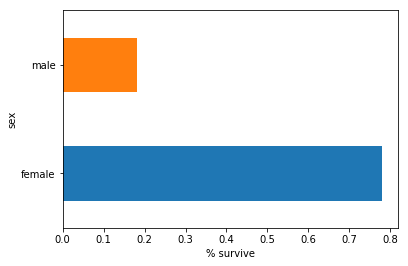

In [16]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [17]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [18]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [19]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'First' b'Third' b'First' b'First' b'Third' b'Third' b'Third'
 b'First' b'First']

A batch of Labels: [0 0 0 1 0 0 1 0 1 1]


In [20]:
print(feature_batch)

{'sex': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'male', b'male', b'female', b'female', b'male', b'male',
       b'female', b'male', b'female', b'female'], dtype=object)>, 'age': <tf.Tensor: shape=(10,), dtype=float64, numpy=array([28., 71., 28., 36., 28., 28., 35., 27., 39., 35.])>, 'n_siblings_spouses': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1])>, 'parch': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])>, 'fare': <tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 15.5   ,  49.5042,   8.05  , 135.6333,  82.1708,   6.95  ,
        20.25  ,   7.8958,  83.1583,  90.    ])>, 'class': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Third', b'First', b'Third', b'First', b'First', b'Third',
       b'Third', b'Third', b'First', b'First'], dtype=object)>, 'deck': <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'unknown', b'unknown', b'unknown', b'C', b'unknown', b'unknown',
       b'unknown',

In [21]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[28.],
       [71.],
       [28.],
       [36.],
       [28.],
       [28.],
       [35.],
       [27.],
       [39.],
       [35.]], dtype=float32)

In [22]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [23]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.83544534, 'auc_precision_recall': 0.794878, 'average_loss': 0.47172755, 'label/mean': 0.375, 'loss': 0.4642221, 'precision': 0.6666667, 'prediction/mean': 0.38745207, 'recall': 0.6666667, 'global_step': 200}


In [24]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [25]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7765151, 'accuracy_baseline': 0.625, 'auc': 0.84863794, 'auc_precision_recall': 0.78188026, 'average_loss': 0.46530882, 'label/mean': 0.375, 'loss': 0.4562329, 'precision': 0.7173913, 'prediction/mean': 0.35685682, 'recall': 0.6666667, 'global_step': 200}


In [26]:
pred_dicts = list(linear_est.predict(eval_input_fn))
print(pred_dicts[0])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/2r/3s13n4bd25z952yxbrmt_fgc0000gn/T/tmp87ufik4d/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([-2.4059417], dtype=float32), 'logistic': array([0.0827207], dtype=float32), 'probabilities': array([0.9172793 , 0.08272073], dtype=float32), 'class_ids': array([0]), 'classes': ar

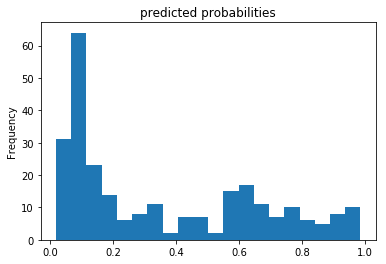

In [27]:
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0, 1.0494949494949495)

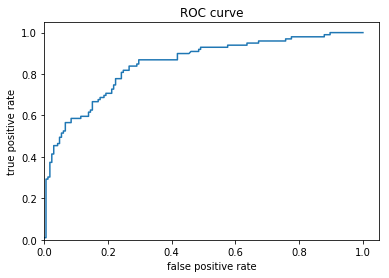

In [28]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

## Boost tree

### 创建特征列和输入函数

In [29]:
fc = tf.feature_column
CATEGORICAL_COLUMNS=['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS=['age','fare']
def one_hot_cat_column(feature_name,vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocab))

feature_columns=[]
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary=dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name,vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    vocalbulary=dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))
    

In [30]:
example=dftrain.head(1)

In [31]:
example

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n


In [32]:
type(example)
example=dict(dftrain.head(1))

In [33]:
example

{'sex': 0    male
 Name: sex, dtype: object, 'age': 0    22.0
 Name: age, dtype: float64, 'n_siblings_spouses': 0    1
 Name: n_siblings_spouses, dtype: int64, 'parch': 0    0
 Name: parch, dtype: int64, 'fare': 0    7.25
 Name: fare, dtype: float64, 'class': 0    Third
 Name: class, dtype: object, 'deck': 0    unknown
 Name: deck, dtype: object, 'embark_town': 0    Southampton
 Name: embark_town, dtype: object, 'alone': 0    n
 Name: alone, dtype: object}

In [34]:
class_fc=tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class',('First', 'Second', 'Third')
                                                                                                     ))
print('Feature value: "{}"'.format(example['class'].iloc[0]))

Feature value: "Third"


In [35]:
print('One-hot encoded:',tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

One-hot encoded: [[0. 0. 1.]]


In [36]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [37]:
# 使用大小为全部数据的 batch ，因为数据规模非常小.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # 对于训练，可以按需多次循环数据集（n_epochs=None）。
        dataset = dataset.repeat(n_epochs)
        # 在内存中训练不使用 batch。
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# 训练与评估的输入函数。
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

### 训练和评估模型

In [38]:
# 初始化模型
linear_est=tf.estimator.LinearClassifier(feature_columns)
# 训练模型
linear_est.train(input_fn=train_input_fn,max_steps=100)

# 评估
result=linear_est.evaluate(eval_input_fn)
clear_output()  # 清除输出
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [ ]:
# 由于数据存入内存中，在每层使用全部数据会更快。
# 上面一个 batch 定义为整个数据集。
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# 一旦建立了指定数量的树，模型将停止训练，
# 而不是基于训练步数。
est.train(train_input_fn, max_steps=1)

# 评估。
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

In [ ]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()